In [1]:
import os
import sys
import glob
import scipy
import numpy as np
import cv2
from PIL import Image
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
from scipy import stats
from matplotlib import pyplot as plt
from sklearn import decomposition

%matplotlib inline
np.set_printoptions(precision=4, linewidth=100)

In [ ]:
# import numpy as np
# from matplotlib.image import imread
# import matplotlib.pyplot as plt
# img = imread('C:/Users/Dell/Desktop/IIMB/data/image/1_3.png')
# def rgb2gray(rgb):
#     r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
#     gray = 0.299 * r + 0.587 * g + 0.114 * b
#     return gray
# M=rgb2gray(img)`
# M = imread('C:/Users/Dell/Desktop/IIMB/data/image/1_3.png')

In [ ]:
M.shape

In [ ]:
plt.imshow(M, cmap='gray')

In [2]:
def bitmap_to_mat(bitmap_seq):
    """from blog.shriphani.com"""
    matrix = []
    shape = None
    for bitmap_file in bitmap_seq:
        img = Image.open(bitmap_file).convert("L")
        if shape is None:
            shape = img.size
        assert img.size == shape
        img = np.array(img.getdata())
        matrix.append(img)
    return np.array(matrix), shape[::-1]

In [3]:
M, shape = bitmap_to_mat(glob.glob("C:/Users/Dell/Desktop/IIMB/data/image/*.png"))
print(M.shape)

(165, 45045)


In [4]:
from __future__ import division, print_function

__all__ = ["pcp"]

import time
import fbpca
import logging
import numpy as np
from scipy.sparse.linalg import svds


def pcp(M, delta=1e-7, mu=None, maxiter=500, verbose=False, missing_data=True,
        svd_method="approximate", **svd_args):
    # Check the SVD method.
    allowed_methods = ["approximate", "exact", "sparse"]
    if svd_method not in allowed_methods:
        raise ValueError("'svd_method' must be one of: {0}"
                         .format(allowed_methods))

    # Check for missing data.
    shape = M.shape
    if missing_data:
        missing = ~(np.isfinite(M))
        if np.any(missing):
            M = np.array(M)
            M[missing] = 0.0
    else:
        missing = np.zeros_like(M, dtype=bool)
        if not np.all(np.isfinite(M)):
            logging.warn("The matrix has non-finite entries. "
                         "SVD will probably fail.")

    # Initialize the tuning parameters.
    lam = 1.0 / np.sqrt(np.max(shape))
    if mu is None:
        mu = 0.25 * np.prod(shape) / np.sum(np.abs(M))
        if verbose:
            print("mu = {0}".format(mu))

    # Convergence criterion.
    norm = np.sum(M ** 2)

    # Iterate.
    i = 0
    rank = np.min(shape)
    S = np.zeros(shape)
    Y = np.zeros(shape)
    d_norm = np.linalg.norm(M, 'fro')
    while i < max(maxiter, 1):
        # SVD step.
        strt = time.time()
        u, s, v = _svd(svd_method, M - S + Y / mu, rank+1, 1./mu, **svd_args)
        svd_time = time.time() - strt

        s = shrink(s, 1./mu)
        rank = np.sum(s > 0.0)
        u, s, v = u[:, :rank], s[:rank], v[:rank, :]
        L = np.dot(u, np.dot(np.diag(s), v))

        # Shrinkage step.
        S = shrink(M - L + Y / mu, lam / mu)

        # Lagrange step.
        step = M - L - S
        step[missing] = 0.0
        Y += mu * step

        # Check for convergence.
        err = np.linalg.norm(step, 'fro') / d_norm
        if verbose:
            print(("Iteration {0}: error={1:.5e}, rank={2:d}, nnz={3:d}, "
                   "time={4:.3e}")
                  .format(i, err, np.sum(s > 0), np.sum(S > 0), svd_time))
        if converged(err, delta):
            break
        i += 1

    if i >= maxiter:
        logging.warn("convergence not reached in pcp")
    return L, S, (u, s, v)


def shrink(M, tau):
    sgn = np.sign(M)
    S = np.abs(M) - tau
    S[S < 0.0] = 0.0
    return sgn * S

def converged(err, delta):
    return err < delta

def _svd(method, X, rank, tol, **args):
    rank = min(rank, np.min(X.shape))
    if method == "approximate":
        return fbpca.pca(X, k=rank, raw=True, **args)
    elif method == "exact":
        return np.linalg.svd(X, full_matrices=False, **args)
    elif method == "sparse":
        if rank >= np.min(X.shape):
            return np.linalg.svd(X, full_matrices=False)
        u, s, v = svds(X, k=rank, tol=tol)
        u, s, v = u[:, ::-1], s[::-1], v[::-1, :]
        return u, s, v
    raise ValueError("invalid SVD method")

In [5]:
L, S, (u, s, v) = pcp(M, maxiter=1000, verbose=True, svd_method="exact")

mu = 0.0018531660096312167
Iteration 0: error=9.22635e-03, rank=161, nnz=814541, time=2.185e+00
Iteration 1: error=6.62431e-04, rank=161, nnz=905891, time=1.800e+00
Iteration 2: error=4.71514e-04, rank=161, nnz=967271, time=1.521e+00
Iteration 3: error=4.77891e-04, rank=161, nnz=1029654, time=1.524e+00
Iteration 4: error=5.04175e-04, rank=161, nnz=1095808, time=1.800e+00
Iteration 5: error=5.29073e-04, rank=161, nnz=1165444, time=1.540e+00
Iteration 6: error=5.51367e-04, rank=161, nnz=1237922, time=1.550e+00
Iteration 7: error=5.69236e-04, rank=160, nnz=1312607, time=1.525e+00
Iteration 8: error=5.84975e-04, rank=160, nnz=1388068, time=1.517e+00
Iteration 9: error=5.94976e-04, rank=158, nnz=1463507, time=1.493e+00
Iteration 10: error=5.99642e-04, rank=156, nnz=1537999, time=1.853e+00
Iteration 11: error=5.97827e-04, rank=154, nnz=1610565, time=1.538e+00
Iteration 12: error=5.94221e-04, rank=153, nnz=1682895, time=1.533e+00
Iteration 13: error=5.87482e-04, rank=152, nnz=1754011, time=1.

Iteration 117: error=4.81888e-05, rank=82, nnz=2993789, time=1.954e+00
Iteration 118: error=4.71985e-05, rank=82, nnz=2994636, time=2.850e+00
Iteration 119: error=4.62589e-05, rank=82, nnz=2995319, time=1.810e+00
Iteration 120: error=4.53765e-05, rank=82, nnz=2995997, time=1.855e+00
Iteration 121: error=4.45138e-05, rank=82, nnz=2996680, time=1.516e+00
Iteration 122: error=4.36684e-05, rank=82, nnz=2997276, time=1.517e+00
Iteration 123: error=4.28291e-05, rank=82, nnz=2997986, time=1.536e+00
Iteration 124: error=4.20052e-05, rank=82, nnz=2998569, time=1.512e+00
Iteration 125: error=4.12000e-05, rank=82, nnz=2999230, time=1.520e+00
Iteration 126: error=4.04274e-05, rank=82, nnz=2999865, time=1.533e+00
Iteration 127: error=3.97186e-05, rank=82, nnz=3000460, time=1.717e+00
Iteration 128: error=3.90517e-05, rank=82, nnz=3001022, time=1.550e+00
Iteration 129: error=3.83680e-05, rank=82, nnz=3001654, time=2.152e+00
Iteration 130: error=3.76968e-05, rank=82, nnz=3002232, time=1.957e+00
Iterat

Iteration 233: error=8.94378e-06, rank=83, nnz=3034344, time=1.584e+00
Iteration 234: error=8.84564e-06, rank=83, nnz=3034519, time=1.944e+00
Iteration 235: error=8.75011e-06, rank=83, nnz=3034693, time=1.534e+00
Iteration 236: error=8.65366e-06, rank=83, nnz=3034853, time=1.649e+00
Iteration 237: error=8.56112e-06, rank=83, nnz=3035020, time=1.639e+00
Iteration 238: error=8.47249e-06, rank=83, nnz=3035180, time=2.606e+00
Iteration 239: error=8.38588e-06, rank=83, nnz=3035345, time=2.000e+00
Iteration 240: error=8.29860e-06, rank=83, nnz=3035493, time=2.757e+00
Iteration 241: error=8.21109e-06, rank=83, nnz=3035692, time=3.037e+00
Iteration 242: error=8.12989e-06, rank=83, nnz=3035855, time=1.817e+00
Iteration 243: error=8.05272e-06, rank=83, nnz=3036027, time=1.517e+00
Iteration 244: error=7.97360e-06, rank=83, nnz=3036189, time=2.255e+00
Iteration 245: error=7.89401e-06, rank=83, nnz=3036334, time=2.034e+00
Iteration 246: error=7.81483e-06, rank=83, nnz=3036510, time=2.134e+00
Iterat

Iteration 349: error=3.55113e-06, rank=84, nnz=3048694, time=1.690e+00
Iteration 350: error=3.53036e-06, rank=84, nnz=3048795, time=1.964e+00
Iteration 351: error=3.50962e-06, rank=84, nnz=3048890, time=1.649e+00
Iteration 352: error=3.48889e-06, rank=84, nnz=3048965, time=1.594e+00
Iteration 353: error=3.46863e-06, rank=84, nnz=3049060, time=1.942e+00
Iteration 354: error=3.44865e-06, rank=84, nnz=3049137, time=1.917e+00
Iteration 355: error=3.42897e-06, rank=84, nnz=3049218, time=1.823e+00
Iteration 356: error=3.40952e-06, rank=84, nnz=3049303, time=1.884e+00
Iteration 357: error=3.39012e-06, rank=84, nnz=3049402, time=1.643e+00
Iteration 358: error=3.37109e-06, rank=84, nnz=3049483, time=1.666e+00
Iteration 359: error=3.35272e-06, rank=84, nnz=3049550, time=1.502e+00
Iteration 360: error=3.33448e-06, rank=84, nnz=3049652, time=1.500e+00
Iteration 361: error=3.31672e-06, rank=84, nnz=3049742, time=1.488e+00
Iteration 362: error=3.29920e-06, rank=84, nnz=3049821, time=1.539e+00
Iterat

Iteration 465: error=2.10282e-06, rank=85, nnz=3056612, time=1.517e+00
Iteration 466: error=2.09532e-06, rank=85, nnz=3056658, time=1.540e+00
Iteration 467: error=2.08788e-06, rank=85, nnz=3056744, time=1.758e+00
Iteration 468: error=2.08040e-06, rank=85, nnz=3056795, time=1.533e+00
Iteration 469: error=2.07252e-06, rank=85, nnz=3056864, time=1.553e+00
Iteration 470: error=2.06495e-06, rank=85, nnz=3056929, time=1.518e+00
Iteration 471: error=2.05770e-06, rank=85, nnz=3056990, time=1.532e+00
Iteration 472: error=2.05067e-06, rank=85, nnz=3057033, time=1.525e+00
Iteration 473: error=2.04347e-06, rank=85, nnz=3057094, time=1.782e+00
Iteration 474: error=2.03627e-06, rank=85, nnz=3057154, time=1.523e+00
Iteration 475: error=2.02906e-06, rank=85, nnz=3057207, time=1.539e+00
Iteration 476: error=2.02231e-06, rank=85, nnz=3057239, time=1.507e+00
Iteration 477: error=2.01556e-06, rank=85, nnz=3057288, time=1.517e+00
Iteration 478: error=2.00871e-06, rank=85, nnz=3057345, time=1.506e+00
Iterat

Iteration 581: error=1.49556e-06, rank=85, nnz=3061811, time=1.728e+00
Iteration 582: error=1.49199e-06, rank=85, nnz=3061844, time=1.540e+00
Iteration 583: error=1.48834e-06, rank=85, nnz=3061882, time=1.576e+00
Iteration 584: error=1.48478e-06, rank=85, nnz=3061910, time=2.501e+00
Iteration 585: error=1.48130e-06, rank=85, nnz=3061937, time=2.031e+00
Iteration 586: error=1.47789e-06, rank=85, nnz=3061986, time=1.603e+00
Iteration 587: error=1.47448e-06, rank=85, nnz=3062022, time=2.383e+00
Iteration 588: error=1.47109e-06, rank=85, nnz=3062059, time=2.583e+00
Iteration 589: error=1.46757e-06, rank=85, nnz=3062106, time=2.422e+00
Iteration 590: error=1.46407e-06, rank=85, nnz=3062144, time=1.908e+00
Iteration 591: error=1.46054e-06, rank=85, nnz=3062180, time=1.573e+00
Iteration 592: error=1.45705e-06, rank=85, nnz=3062216, time=1.533e+00
Iteration 593: error=1.45342e-06, rank=85, nnz=3062237, time=1.600e+00
Iteration 594: error=1.44963e-06, rank=85, nnz=3062301, time=2.117e+00
Iterat

Iteration 697: error=1.15817e-06, rank=85, nnz=3065539, time=2.233e+00
Iteration 698: error=1.15588e-06, rank=85, nnz=3065575, time=1.626e+00
Iteration 699: error=1.15356e-06, rank=85, nnz=3065604, time=1.592e+00
Iteration 700: error=1.15126e-06, rank=85, nnz=3065626, time=1.683e+00
Iteration 701: error=1.14916e-06, rank=85, nnz=3065650, time=1.566e+00
Iteration 702: error=1.14701e-06, rank=85, nnz=3065681, time=1.784e+00
Iteration 703: error=1.14475e-06, rank=85, nnz=3065707, time=1.834e+00
Iteration 704: error=1.14248e-06, rank=85, nnz=3065730, time=1.617e+00
Iteration 705: error=1.14024e-06, rank=85, nnz=3065757, time=1.567e+00
Iteration 706: error=1.13807e-06, rank=85, nnz=3065794, time=1.582e+00
Iteration 707: error=1.13600e-06, rank=85, nnz=3065816, time=1.542e+00
Iteration 708: error=1.13398e-06, rank=85, nnz=3065852, time=1.584e+00
Iteration 709: error=1.13196e-06, rank=85, nnz=3065876, time=1.784e+00
Iteration 710: error=1.12992e-06, rank=85, nnz=3065913, time=1.570e+00
Iterat

Iteration 813: error=9.41221e-07, rank=85, nnz=3068443, time=1.907e+00
Iteration 814: error=9.39627e-07, rank=85, nnz=3068470, time=1.583e+00
Iteration 815: error=9.38085e-07, rank=85, nnz=3068487, time=1.523e+00
Iteration 816: error=9.36586e-07, rank=85, nnz=3068510, time=1.879e+00
Iteration 817: error=9.34915e-07, rank=85, nnz=3068536, time=1.617e+00
Iteration 818: error=9.33359e-07, rank=85, nnz=3068554, time=1.518e+00
Iteration 819: error=9.31792e-07, rank=85, nnz=3068583, time=1.638e+00
Iteration 820: error=9.30178e-07, rank=85, nnz=3068616, time=1.477e+00
Iteration 821: error=9.28490e-07, rank=85, nnz=3068646, time=1.562e+00
Iteration 822: error=9.26836e-07, rank=85, nnz=3068668, time=1.818e+00
Iteration 823: error=9.25297e-07, rank=85, nnz=3068687, time=1.500e+00
Iteration 824: error=9.23774e-07, rank=85, nnz=3068714, time=1.617e+00
Iteration 825: error=9.22259e-07, rank=85, nnz=3068733, time=1.600e+00
Iteration 826: error=9.20779e-07, rank=85, nnz=3068758, time=1.515e+00
Iterat

Iteration 929: error=7.86277e-07, rank=85, nnz=3070734, time=1.533e+00
Iteration 930: error=7.85087e-07, rank=85, nnz=3070757, time=1.505e+00
Iteration 931: error=7.83806e-07, rank=85, nnz=3070777, time=1.929e+00
Iteration 932: error=7.82612e-07, rank=85, nnz=3070799, time=1.583e+00
Iteration 933: error=7.81462e-07, rank=85, nnz=3070813, time=1.533e+00
Iteration 934: error=7.80342e-07, rank=85, nnz=3070836, time=1.517e+00
Iteration 935: error=7.79289e-07, rank=85, nnz=3070855, time=1.567e+00
Iteration 936: error=7.78180e-07, rank=85, nnz=3070881, time=1.572e+00
Iteration 937: error=7.77034e-07, rank=85, nnz=3070908, time=1.812e+00
Iteration 938: error=7.75924e-07, rank=85, nnz=3070927, time=1.563e+00
Iteration 939: error=7.74862e-07, rank=85, nnz=3070954, time=1.581e+00
Iteration 940: error=7.73753e-07, rank=85, nnz=3070976, time=1.515e+00
Iteration 941: error=7.72631e-07, rank=85, nnz=3070992, time=1.567e+00
Iteration 942: error=7.71532e-07, rank=85, nnz=3071012, time=1.582e+00
Iterat

Iteration 999: error=7.13375e-07, rank=85, nnz=3071969, time=1.567e+00


In [ ]:
display(M)
display(L)
display(S)

Text(0.5, 1.0, 'sparse')

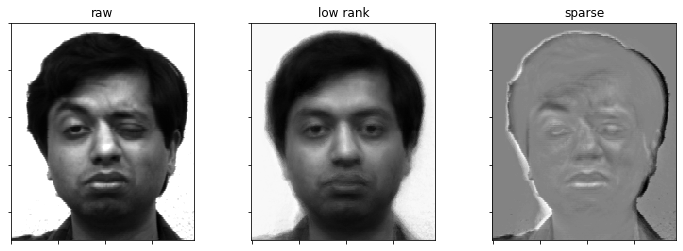

In [8]:
def do_plot(ax, img):
    ax.cla()
    ax.imshow(img.reshape(shape), cmap="gray", interpolation="nearest")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
fig.subplots_adjust(left=0, right=1, hspace=0, wspace=0.01)

do_plot(axes[0], M[2])
axes[0].set_title("raw")
do_plot(axes[1], L[2])
axes[1].set_title("low rank")
do_plot(axes[2], S[2])
axes[2].set_title("sparse")
#fig.savefig("results/{0:05d}.png".format(i))

In [ ]:
# i=0
# fig, axes = plt.subplots(1, 3, figsize=(10, 4))
# fig.subplots_adjust(left=0, right=1, hspace=0, wspace=0.01)
# do_plot(axes[0], M[i])
# axes[0].set_title("raw")
# do_plot(axes[1], L[i])
# axes[1].set_title("low rank")
# do_plot(axes[2], S[i])
# axes[2].set_title("sparse")

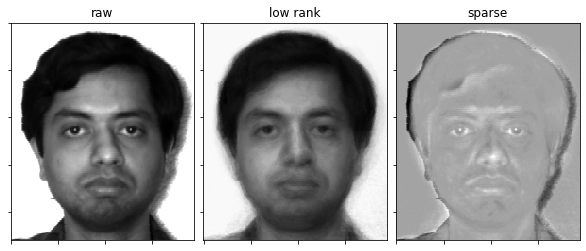

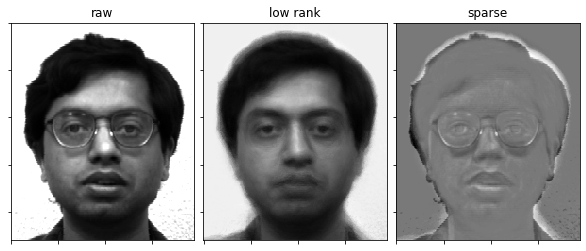

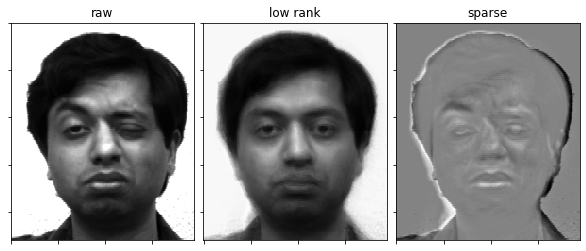

In [18]:
def do_plot(ax, img, shape):
    ax.cla()
    ax.imshow(img.reshape(shape), cmap="gray", interpolation="nearest")
    ax.set_xticklabels([])
    ax.set_yticklabels([])


for i in range(3):
    fig, axes = plt.subplots(1, 3, figsize=(8, 4))
    fig.subplots_adjust(left=0, right=1, hspace=0, wspace=0.01)
    do_plot(axes[0], M[i], shape)
    axes[0].set_title("raw")
    do_plot(axes[1], L[i], shape)
    axes[1].set_title("low rank")
    do_plot(axes[2], S[i], shape)
    axes[2].set_title("sparse")